In [1]:
!pip install tensorflow_recommenders

# Installs and imports
import pandas as pd
import numpy as np
import tensorflow_recommenders as tfrs
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
from typing import Dict, Text
import random
from collections import Counter
import gc
from datetime import timedelta
from IPython.display import clear_output
from tensorflow import feature_column
from tensorflow.keras import layers
import json
clear_output()

In [27]:
def get_top_k_candidates_2_tower(user_set, k, model):
    """
    Generate k candidates from the training set using the two-tower model.

    Args:
        u (str): user ID for which to generate the candidates.
        k (int): Number of candidates to generate.
        model (class): Models to predict the candidate.

    Returns:
        result (list): The top-k candidates.
    """

    size = len(user_set)
    batch_size = 100
    steps = size//batch_size
    if size%batch_size>0:
        steps+=1
        
    result = []
    for i in range(steps):
        userId = user_set[i*(batch_size):(i+1)*batch_size]
        users = {}
        df_tmp = ratingAddFeatures[ratingAddFeatures['userId'].isin(userId)].drop_duplicates(subset='userId')
        if len(df_tmp)>0:
            for column in mvs_categorical_column + users_categorical_column + mvs_numerical_column + users_numerical_column:
                users[column] = tf.constant(df_tmp[column].to_list())
            _, candidates = index(users, k=k)
            candidates = candidates.numpy()
            idx = []
            for x in candidates:
                count = 0
                decode_result = {}
                for c in x:
                    c_decode = c.decode("utf-8")
                    if c_decode not in decode_result:
                        decode_result[c_decode] = 1
                        count += 1
                    if count == k:
                        break
                idx.append(list(decode_result.keys()))
            result.extend(idx)
    return result

In [37]:
def run_candidate_generation(method, common_users, model=None, k_values=[100, 1000], user_set_size=100,
                             id_variable="userId", label_variable="movieId"):
    """
    Evaluate a given candidate generator in terms of recall on the held-out test set.

    Args:
        method (function): Candidate generation function. User ID (u) and number of candidates (k) arguments.
        k_values (list): List of number of candidates to generate and evaluate.
        user_set_size (int): Number of users to evaluate.
        model (class) : Model that we used for prediction. None if we use non-learn model
        common_users (pd.Dataframe): dataframe of common users between (train and validation) or (train and test) to be evaluated.
        columns_model (list of string): List of columns name that used in model. None if we use non-learn model
        id_variable (string): user id column name
        label_variable (string): content id column name

    Returns:
        recall_agg : Statistical Summary of the recall performanec
        result : Recall performance for each of data in common users
    """

    # Initialise evaluation variables
    k_values = sorted(k_values)
    user_set = common_users[:user_set_size]
    result = ratingAddFeatures[ratingAddFeatures['userId'].isin(user_set)].groupby('userId').agg({'movieId': list, 'rating': list}).reset_index()
    result["len"] = result['movieId'].apply(len)

    cg = method(user_set, max(k_values), model)
    for k in k_values:
        result[f"recs@{k}"] = pd.Series(cg).apply(lambda x: x[:k])
        result[f"intersect_len@{k}"] = [len(set(a).intersection(b)) for a, b in
                                        zip(result[label_variable], result[f"recs@{k}"])]
        result[f"recall@{k}"] = result[f"intersect_len@{k}"] / result["len"]

    # Evaluation recall@K
    recall_agg = {}
    for k in k_values:
        recall_agg[k] = {"overall_recall": sum(result[f"recall@{k}"]) / len(result),
                      "min_recall": min(result[f'recall@{k}']),
                      "max_recall": max(result[f'recall@{k}']),
                      "mean_recall": np.mean(result[f'recall@{k}']),
                      "median_recall": np.median(result[f'recall@{k}'])}

    return recall_agg, result

# Load Model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
articles_add = tf.data.Dataset.load('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/articles_add')
ratings = tf.data.Dataset.load('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/rating_tensor')

with open('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/unique_categories.json', 'r') as j:
     unique_categories = json.loads(j.read())

In [6]:
embedding_dimension = 128
tf.keras.utils.set_random_seed(42)
# movies information
mvs_numerical_column = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'movie_age']
mvs_categorical_column = ['id']

#users inforamtion
users_numerical_column = ['total_movies', 'userAvgRating', 'userAvgBudget', 'userAvgPopularity', 
                            'userAvgMovieAge', 'userAvgRuntime']
users_categorical_column = ['userId', 'userTopPH', 'userTopGenres']

class CustomerModelWithAge(tf.keras.Model):
  def __init__(self, ratings, unique_categories):
    super().__init__()
    self.keras_layers = []
    for col in users_categorical_column:
        self.keras_layers.append(tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_categories[col], 
                mask_token=None),
                tf.keras.layers.Embedding(len(unique_categories[col]) + 1, 
                                        embedding_dimension//16)]))
    for col in users_numerical_column:
        self.normalizer = tf.keras.layers.Normalization(axis=None)
        self.normalizer.adapt(ratings.map(lambda x: x[col]).batch(1024))
        self.keras_layers.append(tf.keras.Sequential([self.normalizer, tf.keras.layers.Reshape([1])]))
        
  def call(self, inputs):
    cols = users_categorical_column + users_numerical_column
    return tf.concat([self.keras_layers[i](inputs[cols[i]]) for i in range(len(cols))], axis=1)

class ArticleModelWithProductGroup(tf.keras.Model):
  def __init__(self, ratings, unique_categories):
    super().__init__()
    self.keras_layers = []
    for col in mvs_categorical_column:
        self.keras_layers.append(tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_categories[col], 
                mask_token=None),
                tf.keras.layers.Embedding(len(unique_categories[col]) + 1, 
                                        embedding_dimension//16)]))
    
    for col in mvs_numerical_column:
        self.normalizer = tf.keras.layers.Normalization(axis=None)
        self.normalizer.adapt(ratings.map(lambda x: x[col]).batch(1024))
        self.keras_layers.append(tf.keras.Sequential([self.normalizer, tf.keras.layers.Reshape([1])]))
        
  def call(self, inputs):
    cols = mvs_categorical_column + mvs_numerical_column
    return tf.concat([self.keras_layers[i](inputs[cols[i]]) for i in range(len(cols))], axis=1)

class HandMModelAddFeatures(tfrs.Model):
  def __init__(self, ratings, articles_add, unique_categories):
      super().__init__()
      # Since concatenating additional features varied the feature dimensions
      # Make sure customer and article models output embeddings of compatible size here
      self.customer_model = tf.keras.Sequential([
        CustomerModelWithAge(ratings, unique_categories),
        tf.keras.layers.Dense(embedding_dimension, activation='relu')
      ])
      self.article_model = tf.keras.Sequential([
        ArticleModelWithProductGroup(ratings, unique_categories),
        tf.keras.layers.Dense(embedding_dimension, activation='relu')
      ])
      self.task = tfrs.tasks.Retrieval(
          metrics=tfrs.metrics.FactorizedTopK(
          candidates=articles_add.batch(1024).map(self.article_model),
          ),
      )        

  def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
      # Here we ensure training and query input have same keys 
      # Otherwise the discrepancy in input structure would cause an error when loading the query model after saving it.
      customer_embeddings = self.customer_model({
          col: features[col] for col in users_categorical_column + users_numerical_column
        })
      
      article_embeddings = self.article_model({
          col: features[col] for col in mvs_categorical_column + mvs_numerical_column
        })

      return self.task(customer_embeddings, article_embeddings, compute_metrics=not training)

In [7]:
loaded_model = HandMModelAddFeatures(ratings, articles_add, unique_categories)

In [8]:
loaded_model.load_weights('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/CG_weights')

# Predict

In [9]:
movies_metadata = pd.read_csv("/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/movies_metadata_clean.csv")
users_metadata = pd.read_csv("/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/user_metadata.csv")
rating = pd.read_csv("/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/CG_rating.csv")

In [10]:
test_user = np.random.choice(rating['userId'].unique(),size=500)

In [11]:
rating = rating[rating['userId'].isin(test_user)]
rating[['userId', 'movieId']] = rating[['userId', 'movieId']].astype(str)
movies_metadata['id'] = movies_metadata['id'].astype(str)
users_metadata['userId'] = users_metadata['userId'].astype(str)

In [12]:
ratingAddFeatures = rating.merge(users_metadata, on='userId').merge(movies_metadata, left_on='movieId', right_on='id')
del rating
del users_metadata
del test_user
gc.collect()

1399

In [13]:
article_ds = tf.data.Dataset.from_tensor_slices(dict(movies_metadata[['id']]))
articles = article_ds.map(lambda x: x['id'])

In [14]:
article_add_ds = tf.data.Dataset.from_tensor_slices(dict(movies_metadata[mvs_categorical_column + mvs_numerical_column]))
articles_add = article_add_ds.map(lambda x: {
    col: x[col] for col in mvs_categorical_column + mvs_numerical_column
    })
# ratings = tf.data.Dataset.from_tensor_slices(dict(testAddFeatures[users_numerical_column + mvs_numerical_column]))

In [15]:
# Create an index that takes in raw customer features, and recommends articles out of the entire dataset
index = tfrs.layers.factorized_top_k.BruteForce(loaded_model.customer_model)
index.index_from_dataset(
  tf.data.Dataset.zip((articles.batch(1000), articles_add.batch(1000).map(loaded_model.article_model)))
)

In [16]:
common_users = ratingAddFeatures['userId']

In [17]:
common_users.nunique()

388

In [42]:
performance_test_agg, df_performance_test = run_candidate_generation(get_top_k_candidates_2_tower, common_users, loaded_model, user_set_size=None, k_values=[1000, 5000])

Streaming output truncated to the last 5000 lines.
       105.5, 108. , 107. , 106. , 106. , 107. , 107.5,  95. ,  99. ,
       100.5, 105. ,  96. , 103. , 109. , 100. , 106.5, 102. ,  96.5,
       105. , 107.5, 109. , 105. ,  99. , 106. , 107. , 101. , 117. ,
       113. , 106. ], dtype=float32)>}. Consider rewriting this model with the Functional API.
array([b'141', b'141', b'141', b'141', b'141', b'141', b'141', b'141',
       b'141', b'141', b'141', b'141', b'141', b'141', b'141', b'141',
       b'141', b'141', b'150', b'150', b'150', b'150', b'150', b'150',
       b'150', b'150', b'150', b'150', b'150', b'150', b'150', b'150',
       b'150', b'150', b'150', b'150', b'150', b'150', b'150', b'150',
       b'150', b'150', b'150', b'165', b'165', b'172', b'253', b'253',
       b'253', b'260', b'260', b'260', b'260', b'260', b'296', b'296',
       b'296', b'296', b'457', b'541', b'608', b'1673', b'2762', b'104',
       b'858', b'2692', b'4995', b'58559'], dtype=object)>, 'userId': <tf.

In [43]:
df_performance_test

,userId,movieId,rating,len,recs@1000,intersect_len@1000,recall@1000,recs@5000,intersect_len@5000,recall@5000
0,10143,"[150, 1246, 1580, 364, 588, 1073, 4886, 4995, ...","[5.0, 3.5, 4.0, 3.0, 4.0, 3.5, 5.0, 4.0, 4.5, ...",56,"[64501, 422472, 425002, 420967, 428950, 429039...",0,0.000000,"[64501, 422472, 425002, 420967, 428950, 429039...",7,0.125000
1,10503,"[1884, 1732, 2692, 4011, 4499, 4886, 1968, 261...","[3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 3.0, ...",24,"[67493, 126820, 142051, 67463, 45560, 125336, ...",2,0.083333,"[67493, 126820, 142051, 67463, 45560, 125336, ...",10,0.416667
2,10802,"[260, 541, 608, 1884, 1961, 223, 750, 265, 562...","[4.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, ...",31,"[3024, 3059, 71067, 4196, 2525, 2668, 3026, 24...",3,0.096774,"[3024, 3059, 71067, 4196, 2525, 2668, 3026, 24...",6,0.193548
3,10843,"[296, 653, 344, 648, 780, 539, 95, 317, 410, 4...","[3.0, 3.0, 5.0, 5.0, 5.0, 3.0, 4.0, 3.0, 3.0, ...",12,"[211672, 339403, 297762, 190605, 321612, 67493...",1,0.083333,"[211672, 339403, 297762, 190605, 321612, 67493...",5,0.416667
4,10959,"[150, 165, 318, 380, 457, 480, 593, 292, 377, ...","[4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, ...",24,"[211672, 321612, 297762, 67493, 126820, 142051...",0,0.000000,"[211672, 321612, 297762, 67493, 126820, 142051...",0,0.000000
...,...,...,...,...,...,...,...,...,...,...
383,9714,"[457, 2692, 1394, 1721, 2011, 1273, 1923, 2140...","[4.0, 5.0, 4.0, 5.0, 3.0, 5.0, 3.0, 3.0, 3.0, ...",12,"[67493, 126820, 142051, 67463, 45560, 125336, ...",2,0.166667,"[67493, 126820, 142051, 67463, 45560, 125336, ...",8,0.666667
384,9762,"[150, 1246, 2762, 104, 377, 2502, 4995, 454, 3...","[4.0, 3.5, 3.5, 3.5, 3.0, 3.5, 3.5, 3.0, 3.0, ...",19,"[211672, 321612, 297762, 67493, 126820, 142051...",0,0.000000,"[211672, 321612, 297762, 67493, 126820, 142051...",1,0.052632
385,983,"[150, 480, 593, 608, 924, 1610, 1961, 1073, 20...","[4.5, 3.5, 4.5, 5.0, 4.0, 4.5, 4.5, 3.0, 4.5, ...",25,"[211672, 321612, 297762, 67493, 126820, 19995,...",0,0.000000,"[211672, 321612, 297762, 67493, 126820, 19995,...",0,0.000000
386,9906,"[150, 165, 253, 296, 318, 380, 457, 480, 292, ...","[4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 4.0, 3.0, ...",35,"[211672, 67493, 126820, 142051, 321612, 297762...",1,0.028571,"[211672, 67493, 126820, 142051, 321612, 297762...",2,0.057143


<Axes: ylabel='Frequency'>

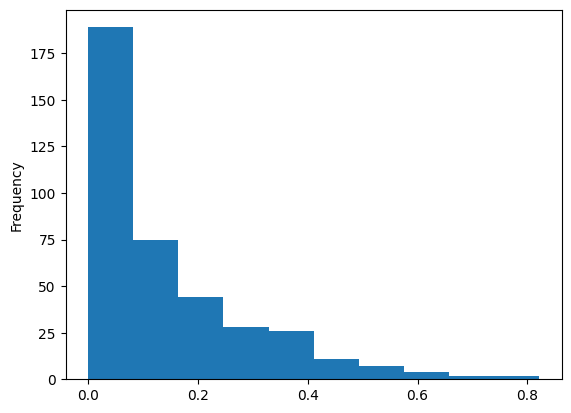

In [44]:
df_performance_test['recall@5000'].plot.hist()

In [45]:
performance_test_agg

{1000: {'overall_recall': 0.029438909830928076,
  'min_recall': 0.0,
  'max_recall': 0.4642857142857143,
  'mean_recall': 0.029438909830928086,
  'median_recall': 0.0},
 5000: {'overall_recall': 0.1351031934865802,
  'min_recall': 0.0,
  'max_recall': 0.8214285714285714,
  'mean_recall': 0.13510319348658015,
  'median_recall': 0.08696309739866909}}

In [46]:
df_performance_test.to_csv('/content/drive/MyDrive/💡Learning Artificial Intelligence/Tensorflow Recommender/CG_result.csv', index=False)

In [33]:
k_values = [100]
user_set_size = 10
method = get_top_k_candidates_2_tower
label_variable='movieId'
model = loaded_model

k_values = sorted(k_values)
user_set = common_users[:user_set_size]
result = ratingAddFeatures[ratingAddFeatures['userId'].isin(user_set)].groupby('userId').agg({'movieId': list}, {'rating': list}).reset_index()
result["len"] = result['movieId'].apply(len)

cg = method(user_set, max(k_values), model)
for k in k_values:
    result[f"recs@{k}"] = pd.Series(cg).apply(lambda x: x[:k])
    result[f"intersect_len@{k}"] = [len(set(a).intersection(b)) for a, b in
                                    zip(result[label_variable], result[f"recs@{k}"])]
    result[f"recall@{k}"] = result[f"intersect_len@{k}"] / result["len"]


array([b'141', b'141', b'141', b'141', b'141', b'141', b'141', b'141',
       b'141', b'141'], dtype=object)>, 'userId': <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'269', b'872', b'2217', b'2672', b'3999', b'4066', b'4369',
       b'7069', b'8653', b'8979'], dtype=object)>, 'userTopPH': <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'Columbia Pictures', b'Metro-Goldwyn-Mayer (MGM)',
       b'Twentieth Century Fox Film Corporation',
       b'Lakeshore Entertainment', b'Universal Pictures', b'Warner Bros.',
       b'Paramount Pictures', b'Warner Bros.',
       b'Metro-Goldwyn-Mayer (MGM)', b'Paramount Pictures'], dtype=object)>, 'userTopGenres': <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'Action', b'Comedy', b'Thriller', b'Comedy', b'Comedy',
       b'Thriller', b'Thriller', b'Comedy', b'Thriller', b'Thriller'],
      dtype=object)>, 'budget': <tf.Tensor: shape=(10,), dtype=int32, numpy=
array([6000000, 6000000, 6000000, 6000000, 6000000, 6000000, 6000000,
  